## 1. Data Ingestion

The `diamonds` dataset has been widely used in data science and machine learning. We will use it to demonstrate Snowflake's native data science transformers in terms of database functionality and Spark & Pandas comportablity, using non-synthetic and statistically appropriate data that is well known to the ML community.



### Establish Secure Connection to Snowflake

*Other connection options include Username/Password, MFA, OAuth, Okta, SSO. For more information, refer to the [Python Connector](https://docs.snowflake.com/en/developer-guide/python-connector/python-connector-example) documentation.*

### Import Libraries

In [1]:
# Snowpark for Python
from snowflake.snowpark import Session
from snowflake.snowpark.version import VERSION
from snowflake.snowpark.types import StructType, StructField, DoubleType, StringType
import snowflake.snowpark.functions as F

# data science libs
import numpy as np

# misc
import json

In [4]:
import pandas as pd

In [2]:
# Make a Snowpark Connection

################################################################################################################
#  You can also use the SnowSQL Client to configure your connection params:
#  https://docs.snowflake.com/en/user-guide/snowsql-install-config.html
#
#  >>> from snowflake.ml.utils import connection_params
#  >>> session = Session.builder.configs(connection_params.SnowflakeLoginOptions()
#  >>> ).create()   
#
#  NOTE: If you have named connection params then specify the connection name
#  Example:
#  
#  >>> session = Session.builder.configs(
#  >>> connection_params.SnowflakeLoginOptions(connection_name='connections.snowml')
#  >>> ).create()
#
#################################################################################################################

# Edit the connection.json before creating the session object below
# Create Snowflake Session object
connection_parameters = json.load(open('connection.json'))
session = Session.builder.configs(connection_parameters).create()
session.sql_simplifier_enabled = True

snowflake_environment = session.sql('SELECT current_user(), current_version()').collect()
snowpark_version = VERSION

# Current Environment Details
print('\nConnection Established with the following parameters:')
print('User                        : {}'.format(snowflake_environment[0][0]))
print('Role                        : {}'.format(session.get_current_role()))
print('Database                    : {}'.format(session.get_current_database()))
print('Schema                      : {}'.format(session.get_current_schema()))
print('Warehouse                   : {}'.format(session.get_current_warehouse()))
print('Snowflake version           : {}'.format(snowflake_environment[0][1]))
print('Snowpark for Python version : {}.{}.{}'.format(snowpark_version[0],snowpark_version[1],snowpark_version[2]))


Connection Established with the following parameters:
User                        : LION
Role                        : "TRAINING_ROLE"
Database                    : "HACKATHON_ALGORITHM_AVENGERS"
Schema                      : "PROCUREMENT_ON_TIME_DELIVERY"
Warehouse                   : "U"
Snowflake version           : 8.9.1
Snowpark for Python version : 1.13.0


In [3]:
# Show the file before loading
session.sql("DESCRIBE TABLE PROCUREMENT_ON_TIME_DELIVERY.PURCHASE_ORDER_HISTORY;").show()

df = session.read.options({"field_delimiter": ",",
                                    "field_optionally_enclosed_by": '"',
                                    "infer_schema": True,
                                    "parse_header": True}).table("PROCUREMENT_ON_TIME_DELIVERY.PURCHASE_ORDER_HISTORY")

# Select only three columns from the DataFrame
#selected_df = df.select("PURCHASE_DOCUMENT_ID", "CREATE_DATE", "COMPANY_CODE_ID")

# Show the selected columns
#selected_df.show()

koch = df.to_pandas()

---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
|"name"                     |"type"             |"kind"  |"null?"  |"default"  |"primary key"  |"unique key"  |"check"  |"expression"  |"comment"  |"policy name"  |"privacy domain"  |
---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
|PURCHASE_DOCUMENT_ID       |NUMBER(38,0)       |COLUMN  |Y        |NULL       |N              |N             |NULL     |NULL          |NULL       |NULL           |NULL              |
|CREATE_DATE                |NUMBER(38,0)       |COLUMN  |Y        |NULL       |N              |N             |NULL     |NULL          |NULL       |NULL           |NULL              |
|COMPANY_CODE_ID            |VARCHAR(16777216)  |COLUMN  |Y        |NULL       |

In [6]:
koch.to_csv("koch.csv")

In [165]:
import pandas as pd
import numpy as np

date_columns = ['POR_DELIVERY_DATE', 'DELIVERY_DATE', 'REQUESTED_DELIVERY_DATE', 'FIRST_GR_POSTING_DATE','CREATE_DATE']

for column in date_columns:
    temp_series = koch[column].fillna(0).astype(int).astype(str)
    
    # Replace '0' string back to NaN to avoid incorrect date conversion
    temp_series = temp_series.replace('0', np.nan)
    
    # Convert to datetime
    koch[column] = pd.to_datetime(temp_series, format='%Y%m%d', errors='coerce')

#Creating target column
koch['Time_Difference'] = koch['FIRST_GR_POSTING_DATE'] - koch['DELIVERY_DATE']

koch['Time_Difference'] = koch['Time_Difference'].dt.days

fallback_diff = (koch['REQUESTED_DELIVERY_DATE'] - koch['DELIVERY_DATE']).dt.days

# Fill in Time_Difference where it's NaN with the fallback difference
koch['Time_Difference'] = np.where(koch['Time_Difference'].isna(), fallback_diff, koch['Time_Difference'])

def determine_status(days):
    if days < 0:
        return 'Early'
    elif days == 0:
        return 'On Time'
    else:
        return 'Late'

# Assuming 'Time_Difference' is your column with the date difference in days
koch['Arrival_Status'] = koch['Time_Difference'].apply(determine_status)


rows = [22641, 115701, 358807, 484118, 489462, 524500, 524553, 524570,
        524667, 524670, 524698, 592204, 614500, 745948, 947446]

# Drop rows based on indices
koch = koch.drop(rows)


koch['country'] = koch['COMPANY_CODE_ID'].str.slice(0, 2)
koch['region'] = koch['COMPANY_CODE_ID'].str.slice(2, 4)

koch = koch[koch['DELIVERY_DATE'] >= koch['CREATE_DATE']]

from datetime import datetime, timedelta

# Get tomorrow's date for comparison
tomorrow = datetime.today().date() + timedelta(days=1)

# Filter rows where 'DELIVERY_DATE' is tomorrow or in the future
koch = koch[koch['DELIVERY_DATE'].dt.date <= tomorrow]





In [62]:
def determine_status(days):
    if days < 0:
        return 'Early'
    elif days == 0:
        return 'On Time'
    else:
        return 'Late'

# Assuming 'Time_Difference' is your column with the date difference in days
koch['Arrival_Status'] = koch['Time_Difference'].apply(determine_status)


In [ ]:
rows = [22641, 115701, 358807, 484118, 489462, 524500, 524553, 524570,
        524667, 524670, 524698, 592204, 614500, 745948, 947446]

# Drop rows based on indices
koch = koch.drop(rows)

In [ ]:
koch['country'] = koch['COMPANY_CODE_ID'].str.slice(0, 2)
koch['region'] = koch['COMPANY_CODE_ID'].str.slice(2, 4)

In [ ]:
koch.shape

(1139392, 25)

In [70]:
koch = koch[koch['DELIVERY_DATE'] >= koch['CREATE_DATE']]

from datetime import datetime, timedelta

# Get tomorrow's date for comparison
tomorrow = datetime.today().date() + timedelta(days=1)

# Filter rows where 'DELIVERY_DATE' is tomorrow or in the future
koch = koch[koch['DELIVERY_DATE'].dt.date <= tomorrow]

In [ ]:
weiurdkoch[koch['DELIVERY_DATE'] >= koch['CREATE_DATE']]

In [ ]:
graph1 = koch.groupby(['DELIVERY_DATE', 'Arrival_Status']).size().reset_index(name='Count')

# Sort the resulting DataFrame by 'DELIVERY_DATE'
graph1 = graph1.sort_values(by='DELIVERY_DATE', ascending=False)


import seaborn as sns
import matplotlib.pyplot as plt

# Assuming 'graph1' is your DataFrame

# Create a FacetGrid with 'ARRIVAL_STATUS' for creating separate subplots for each unique value in 'ARRIVAL_STATUS'
graph_1 = sns.FacetGrid(graph1, col="Arrival_Status", col_wrap=4, sharex=False, sharey=False)  # Adjust 'col_wrap' as needed

# Map a lineplot onto each subplot by specifying the x and y axis and the 'hue' for coloring different 'Arrival_Status' within each subplot
graph_1.map(sns.lineplot, "DELIVERY_DATE", "Count", "Arrival_Status", marker="o")

# Adding a legend and adjusting subplot titles
graph_1.add_legend()
graph_1.set_titles("{col_name}")

# Optionally, adjust the layout so plots don't overlap
plt.tight_layout()

# Show the plot
plt.show()


In [71]:
graph1 = koch.groupby(['DELIVERY_DATE', 'Arrival_Status']).size().reset_index(name='Count')

# Sort the resulting DataFrame by 'DELIVERY_DATE'
graph1 = graph1.sort_values(by='DELIVERY_DATE', ascending=False)

graph1

,DELIVERY_DATE,Arrival_Status,Count
5821,2024-03-03,On Time,1
5820,2024-03-02,Early,1
5819,2024-03-01,On Time,1
5818,2024-02-29,On Time,24
5817,2024-02-29,Early,1
...,...,...,...
5,2018-09-09,On Time,1
2,2018-09-08,Late,120
3,2018-09-08,On Time,2
1,2018-09-07,On Time,34


In [172]:

original_count = len(koch)

weird_dates_df = koch[koch['DELIVERY_DATE'] > koch['CREATE_DATE']]
filtered_count = len(weird_dates_df)

# Calculate the number of dropped rows
dropped_count = original_count - filtered_count

print(f"Number of rows dropped: {dropped_count}")



Number of rows dropped: 90962


In [171]:

original_count = len(koch)
# Get tomorrow's date for comparison
tomorrow = datetime.today().date() + timedelta(days=1)

# Filter rows where 'DELIVERY_DATE' is tomorrow or in the future
more_weird = koch[koch['DELIVERY_DATE'].dt.date <= tomorrow]

# Get the count of the filtered rows
more_weird_count = len(more_weird)

# Calculate the number of rows dropped
dropped_count_2 = original_count - more_weird_count

print(f"Number of rows dropped: {dropped_count_2}")


Number of rows dropped: 0


In [145]:
# Group by 'DELIVERY_DATE' and 'Arrival_Status', and count the occurrences
graph_data = koch.groupby(['DELIVERY_DATE', 'Arrival_Status']).size().reset_index(name='Count')

# Sort the resulting DataFrame by 'DELIVERY_DATE'
graph_data = graph_data.sort_values(by='DELIVERY_DATE')

graph_data

,DELIVERY_DATE,Arrival_Status,Count
0,2018-09-07,Late,8
1,2018-09-07,On Time,34
2,2018-09-08,Late,120
3,2018-09-08,On Time,2
4,2018-09-09,Late,6
...,...,...,...
5818,2024-02-29,On Time,24
5817,2024-02-29,Early,1
5819,2024-03-01,On Time,1
5820,2024-03-02,Early,1


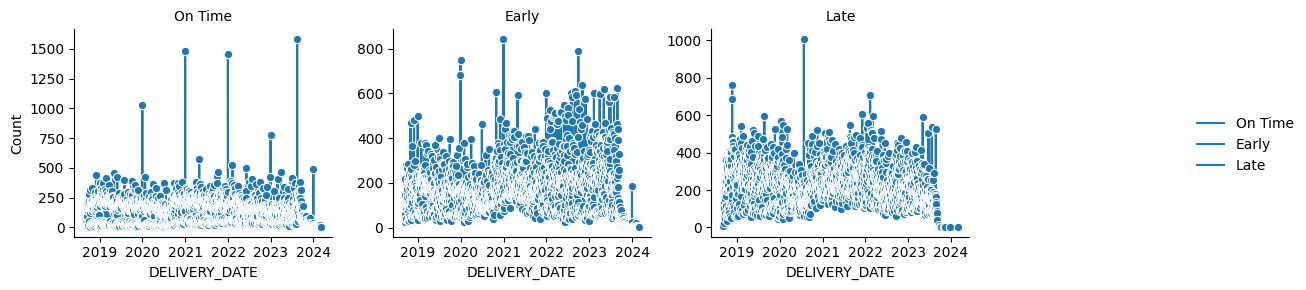

In [146]:
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming 'graph1' is your DataFrame

# Create a FacetGrid with 'ARRIVAL_STATUS' for creating separate subplots for each unique value in 'ARRIVAL_STATUS'
graph_1 = sns.FacetGrid(graph1, col="Arrival_Status", col_wrap=4, sharex=False, sharey=False)  # Adjust 'col_wrap' as needed

# Map a lineplot onto each subplot by specifying the x and y axis and the 'hue' for coloring different 'Arrival_Status' within each subplot
graph_1.map(sns.lineplot, "DELIVERY_DATE", "Count", "Arrival_Status", marker="o")

# Adding a legend and adjusting subplot titles
graph_1.add_legend()
graph_1.set_titles("{col_name}")

# Optionally, adjust the layout so plots don't overlap
plt.tight_layout()

# Show the plot
plt.show()

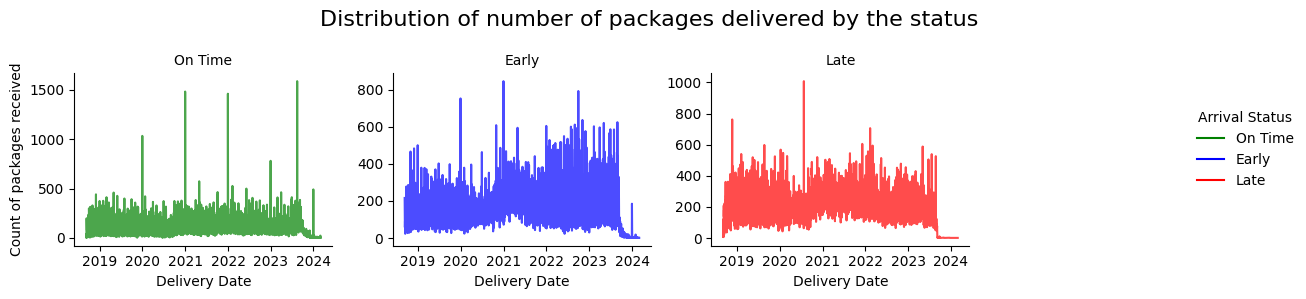

In [90]:
import seaborn as sns
import matplotlib.pyplot as plt

# Define your custom color palette for each 'Arrival_Status'
color_palette = {
    "On Time": "green",  # Ensure this matches exactly with your DataFrame's 'Arrival_Status' values
    "Late": "red",
    "Early": "blue"  # Corrected 'golden' to 'gold', which is a valid color name
}

# Create a FacetGrid
g = sns.FacetGrid(graph1, col="Arrival_Status", col_wrap=4, sharex=False, sharey=False)

# Use map_dataframe to apply sns.lineplot
g.map_dataframe(sns.lineplot, x="DELIVERY_DATE", y="Count", hue="Arrival_Status", palette=color_palette, alpha =.7)

# Add a legend and adjust subplot titles
g.add_legend(title="Arrival Status")
g.set_titles("{col_name}")

# Set custom axis labels
g.set_axis_labels("Delivery Date", "Count of packages received")

# Set the overall title for the figure
g.fig.suptitle('Distribution of number of packages delivered by the status', fontsize=16)

# Optionally, adjust the layout
plt.tight_layout()

# Show the plot
plt.show()


In [168]:
import pandas as pd

# Ensure that 'CREATE_DATE' is a datetime column
koch['CREATE_DATE'] = pd.to_datetime(koch['CREATE_DATE'])
# Extract the year from 'CREATE_DATE'
koch['Year'] = koch['CREATE_DATE'].dt.year

# Calculate the average 'Time_Difference' per 'MATERIAL_ID' and 'Year'
material_delays = koch.groupby(['MATERIAL_ID', 'Year'])['Time_Difference'].mean().reset_index()

# Get top 5 materials with the highest average delay per year
top_materials = material_delays.sort_values('Time_Difference', ascending=False).groupby('Year').head(5)

# Get bottom 5 materials with the lowest average delay per year
bottom_materials = material_delays.sort_values('Time_Difference', ascending=True).groupby('Year').head(5)


In [169]:
top_materials.head(5)

,MATERIAL_ID,Year,Time_Difference
61623,2.100009e+09,2018,1627.0
63904,2.100031e+09,2019,1489.0
60666,2.100008e+09,2019,1321.0
60088,2.100008e+09,2020,1175.5
61849,2.100009e+09,2020,1066.0


In [170]:
bottom_materials.head(5)

,MATERIAL_ID,Year,Time_Difference
44804,1.100261e+09,2021,-585.0
54072,1.100275e+09,2022,-516.0
54045,1.100275e+09,2022,-516.0
41686,1.100255e+09,2022,-488.0
41357,1.100254e+09,2018,-480.5


In [118]:
# Convert 'Delivery_Date' to datetime if it's not already
graph2 = graph1



# Extract month name and year from 'Delivery_Date'
graph2['Month'] = graph2['DELIVERY_DATE2'].dt.month_name()
graph2['Year'] = graph2['DELIVERY_DATE2'].dt.year.astype(str)  # Convert year to string for categorical plotting


graph2


,DELIVERY_DATE,Arrival_Status,Count,DELIVERY_DATE2,Month,Year,Month_Name
5821,2024-03-03,On Time,1,2024-03-03,March,2024,March
5820,2024-03-02,Early,1,2024-03-02,March,2024,March
5819,2024-03-01,On Time,1,2024-03-01,March,2024,March
5818,2024-02-29,On Time,24,2024-02-29,February,2024,February
5817,2024-02-29,Early,1,2024-02-29,February,2024,February
...,...,...,...,...,...,...,...
5,2018-09-09,On Time,1,2018-09-09,September,2018,September
2,2018-09-08,Late,120,2018-09-08,September,2018,September
3,2018-09-08,On Time,2,2018-09-08,September,2018,September
1,2018-09-07,On Time,34,2018-09-07,September,2018,September


C:\Users\Dann_\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\seaborn\axisgrid.py:848: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  func(*plot_args, **plot_kwargs)
C:\Users\Dann_\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\seaborn\axisgrid.py:848: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  func(*plot_args, **plot_kwargs)
C:\Users\Dann_\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\seaborn\axisgrid.py:848: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  func(*plot_args, **plot_kwargs)


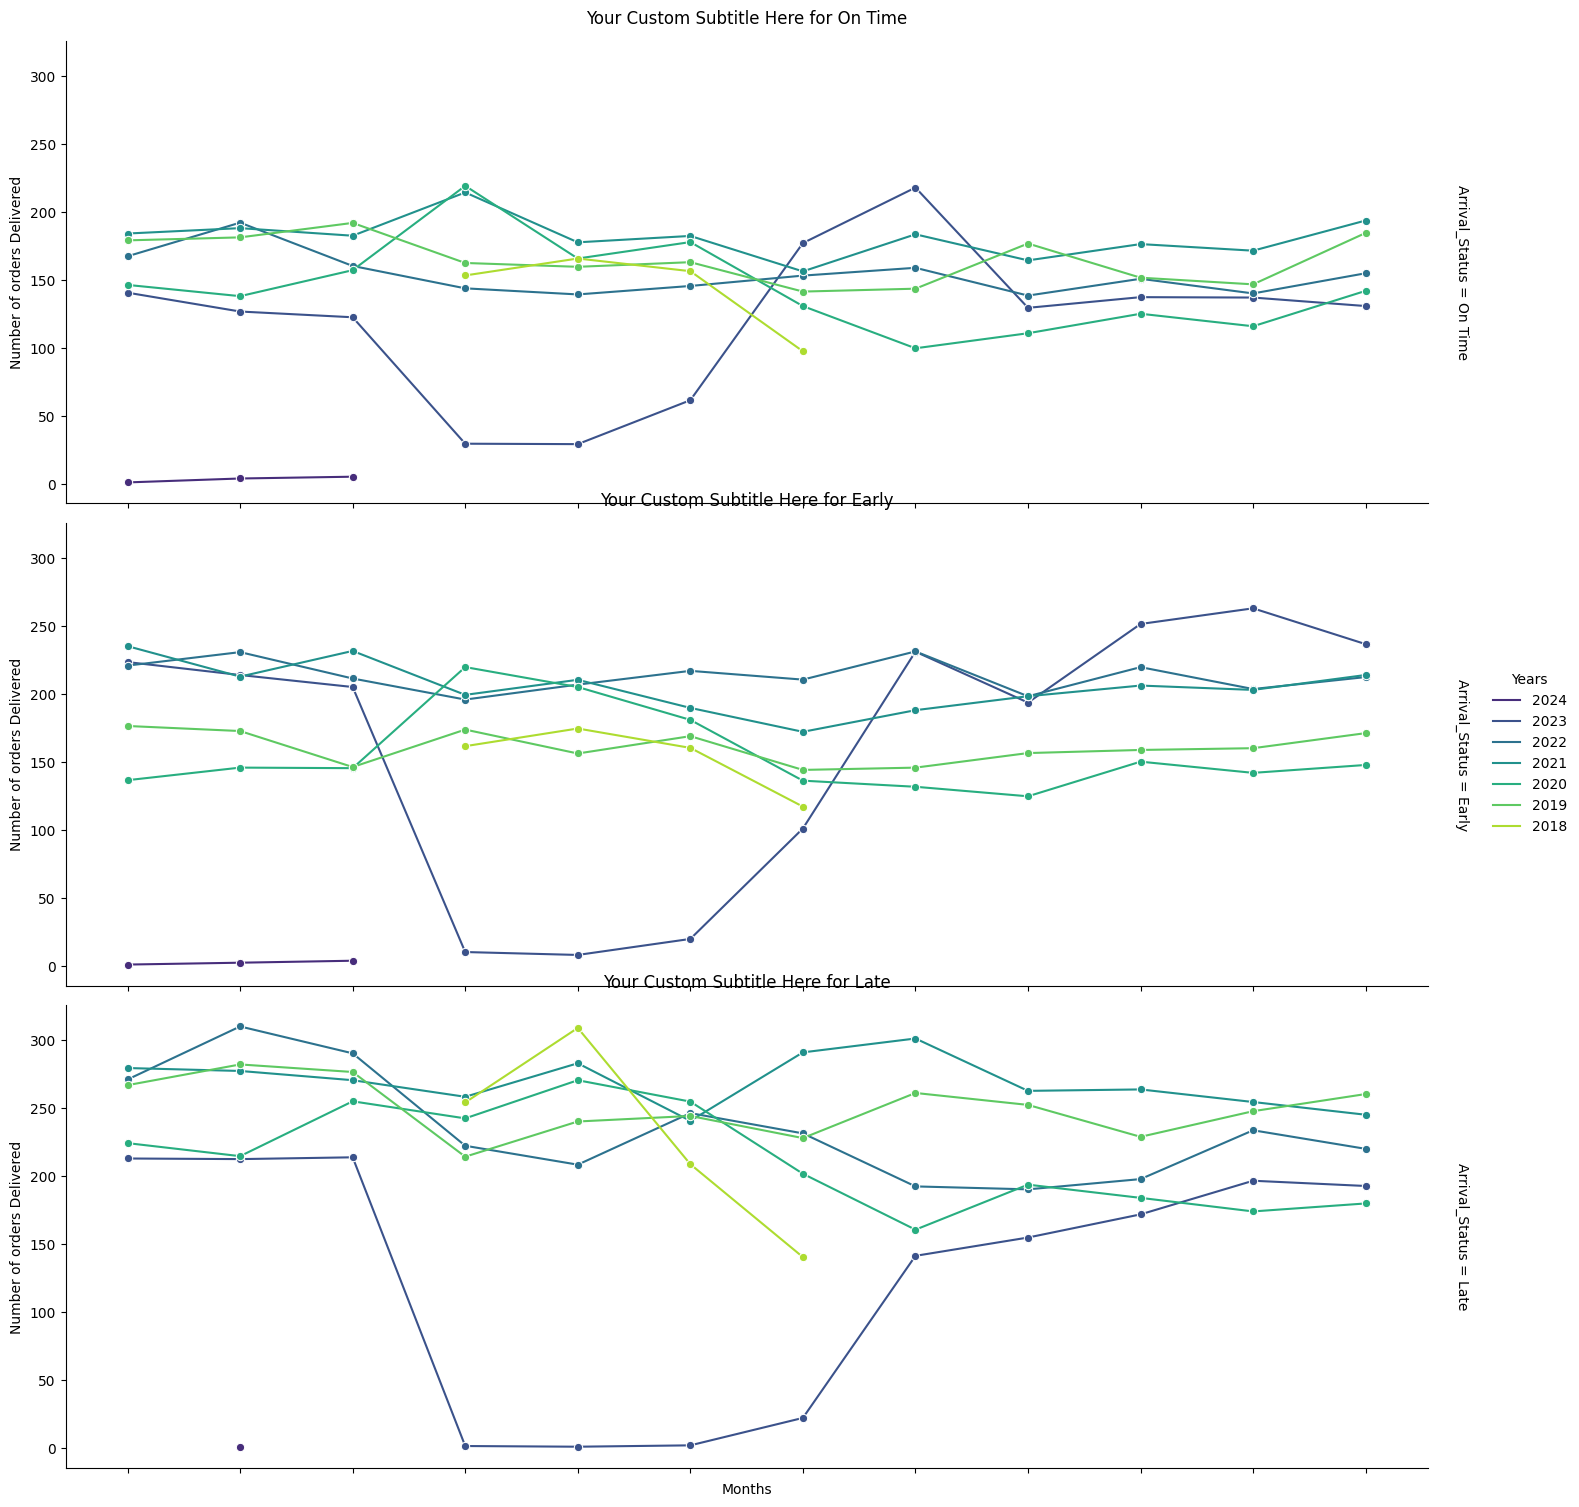

In [138]:

# Assuming 'df' is your DataFrame

# Create a FacetGrid, with rows for each 'Arrival_Status'
g = sns.FacetGrid(graph2, row='Arrival_Status', height=5, aspect=3, margin_titles=True)

# Map the data to lineplots
g.map(sns.lineplot, 'Month_Name', 'Count', 'Year', marker="o", palette='viridis', ci=None)

g.set_axis_labels('Months', 'Number of orders Delivered')
g.set_titles('{row_name}')
g.add_legend(title='Years')
g.set_xticklabels(rotation=45)
for ax, status in zip(g.axes.flatten(), graph2['Arrival_Status'].unique()):
    ax.set_title(f'Your Custom Subtitle Here for {status}', y=1.02) # You can adjust the y value as needed

# Show plot
plt.show()


# Show plot
plt.show()




<Figure size 1200x600 with 0 Axes>

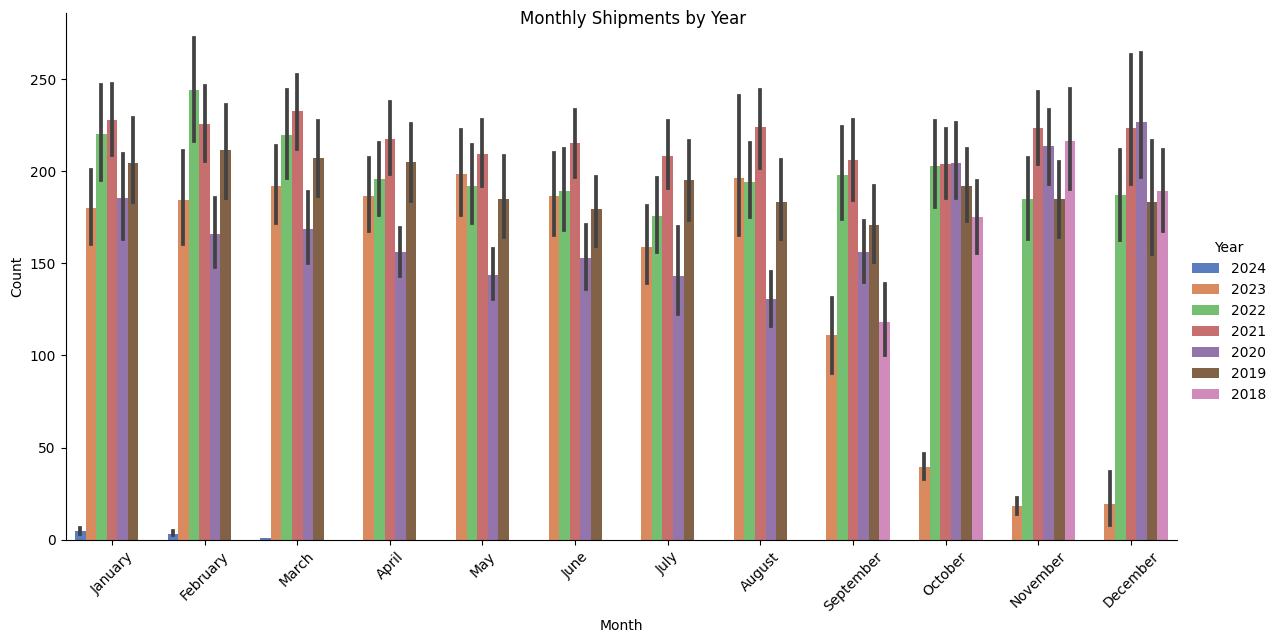

In [142]:
import seaborn as sns
import matplotlib.pyplot as plt

# Create the main graph
plt.figure(figsize=(12, 6))
g = sns.catplot(x='Month', y='Count', hue='Year', data=graph1, kind='bar', height=6, aspect=2, palette='muted', order=['January', 'February', 'March', 'April', 'May', 'June', 'July', 'August', 'September', 'October', 'November', 'December'])
g.set_axis_labels("Month", "Count")
g.fig.suptitle('Monthly Shipments by Year')

# Rotate x-axis labels for readability if needed
plt.xticks(rotation=45)

# Show plot
plt.show()


In [111]:
import pandas as pd

# Assuming 'Delivery_Date' is in datetime format. If not, convert it first:
# graph1['Delivery_Date'] = pd.to_datetime(graph1['Delivery_Date'])

# Extract month and year from 'Delivery_Date'
graph2['Month'] = graph2['DELIVERY_DATE'].dt.month
graph1['Year'] = graph1['DELIVERY_DATE'].dt.year

# Optionally, convert 'Month' from numbers to names for better readability in the plots
graph1['Month_Name'] = graph1['DELIVERY_DATE'].dt.strftime('%B')


C:\Users\Dann_\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\seaborn\axisgrid.py:848: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  func(*plot_args, **plot_kwargs)
C:\Users\Dann_\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\seaborn\axisgrid.py:848: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  func(*plot_args, **plot_kwargs)
C:\Users\Dann_\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\seaborn\axisgrid.py:848: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  func(*plot_args, **plot_kwargs)


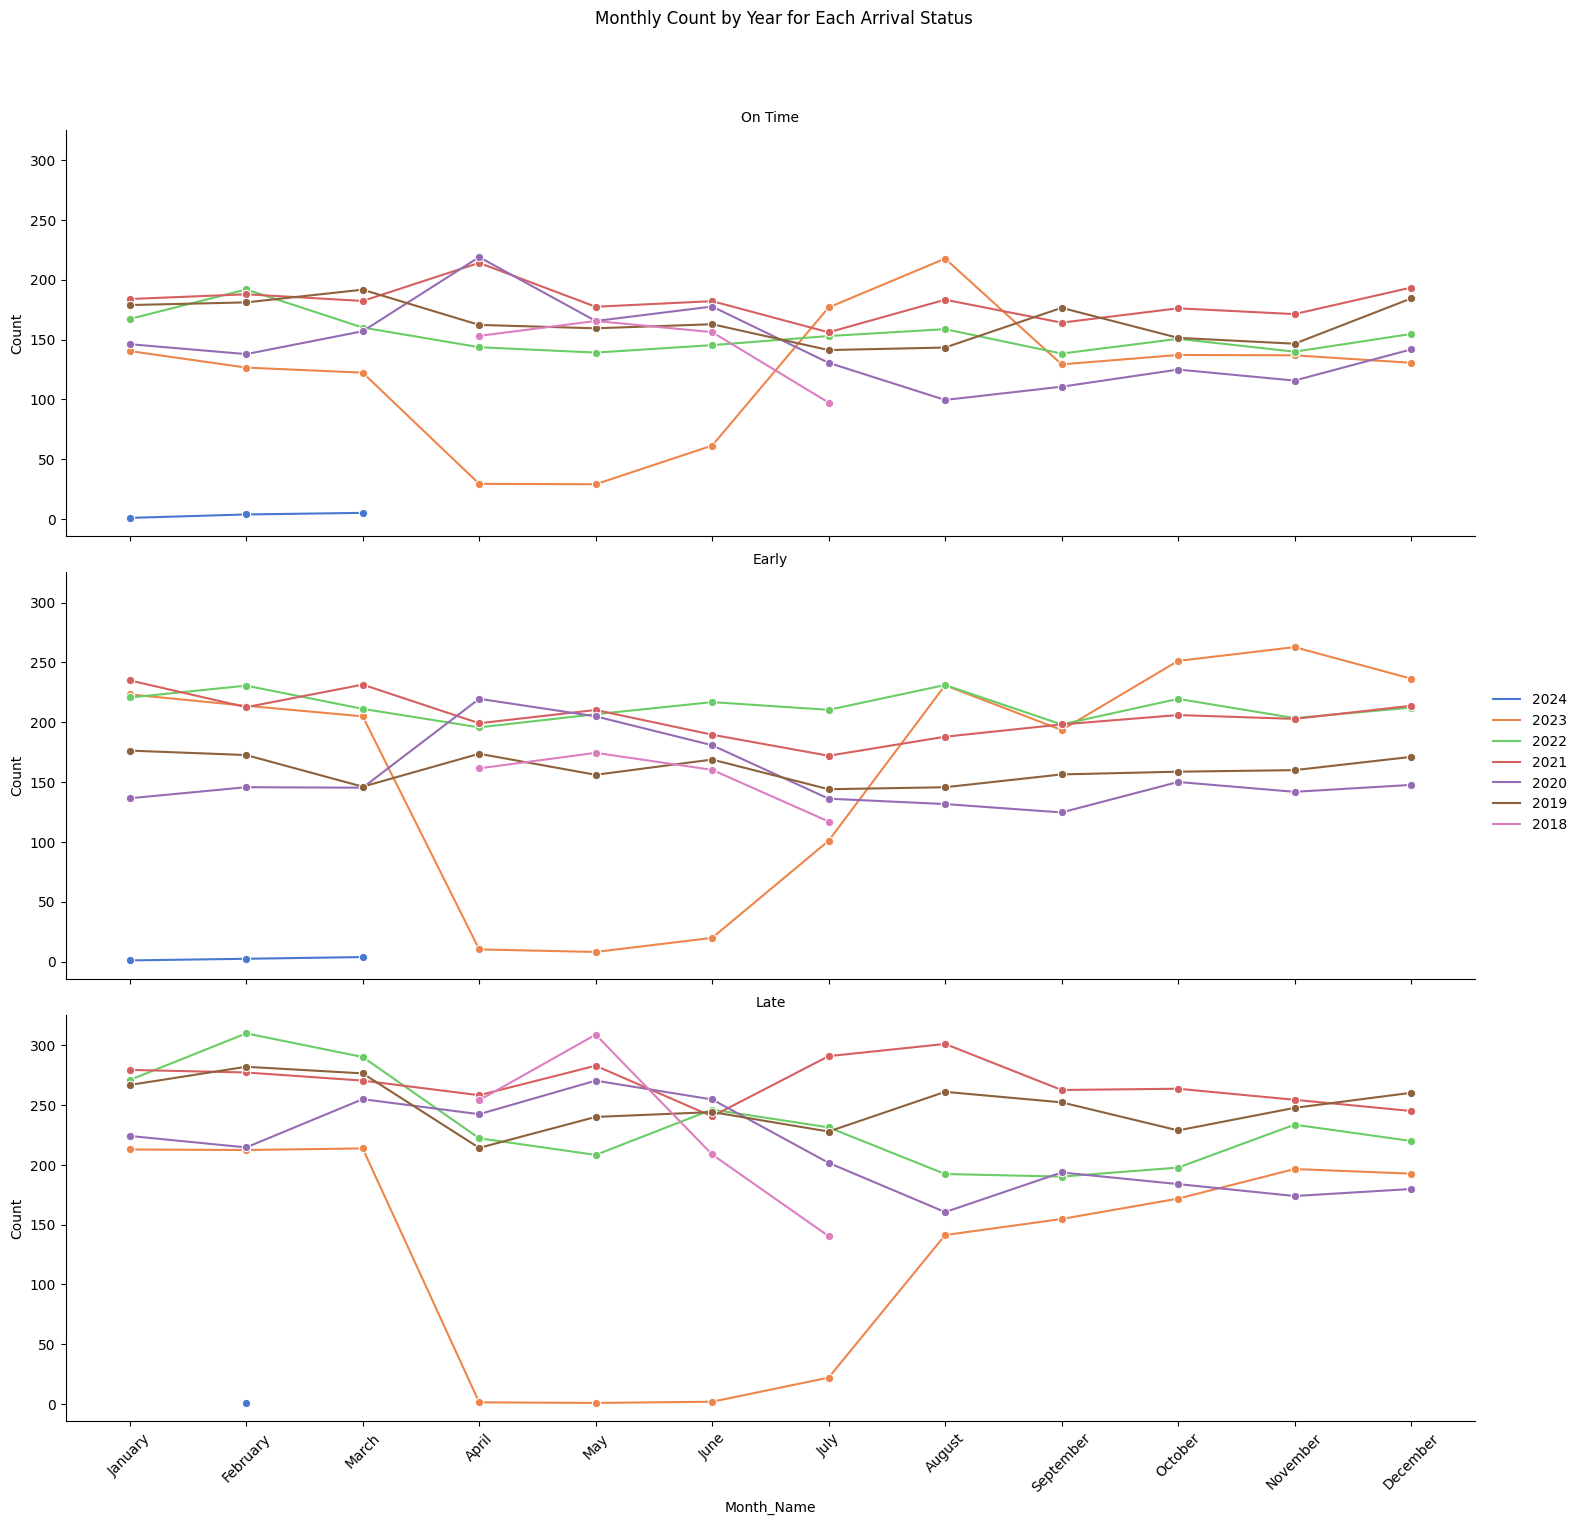

In [141]:
# Create mini multiple plots
g = sns.FacetGrid(graph2, col="Arrival_Status", col_wrap=1, height=5, aspect=3, margin_titles=True)

g.map_dataframe(sns.lineplot, x='Month_Name', y='Count', hue='Year', palette='muted', marker='o', ci=None)

# Adjust the mini plots
g.set_xticklabels(rotation=45)  # Rotate x-axis labels for readability
g.add_legend()  # Add legend
g.set_titles("{col_name}")  # Set title for each subplot
g.fig.subplots_adjust(top=0.9)
g.fig.suptitle('Monthly Count by Year for Each Arrival Status')

order = ['January', 'February', 'March', 'April', 'May', 'June', 'July', 'August', 'September', 'October', 'November', 'December']
plt.xticks(range(len(order)), order, rotation=45)

# Show the plot
plt.show()


In [169]:
koch_1.shape

(180306, 23)

In [170]:
koch_2 = koch[koch['DELIVERY_DATE'].isna()]

In [171]:
koch_2.shape

(45636, 23)

In [157]:
# Filter rows where both 'FIRST_GR_POSTING_DATE' and 'SECOND_COLUMN' are null
koch_3 = koch[koch['FIRST_GR_POSTING_DATE'].isna() & koch['DELIVERY_DATE'].isna()]


In [138]:
### THIS WE DON'T KNOW
# Attempt to convert 'PLANNED_DELIVERY_DAYS' to numeric, forcing non-convertible values to NaN
koch_3['PLANNED_DELIVERY_DAYS_numeric'] = pd.to_numeric(koch_3['PLANNED_DELIVERY_DAYS'], errors='coerce')

rows = [ 22641, 115701, 358807, 484118, 489462, 524500, 524553, 524570,
            524667, 524670, 524698, 592204, 614500, 745948, 947446]

filtered_rows = koch_3.query("index in @rows")



C:\Users\Dann_\AppData\Local\Temp\ipykernel_31276\2660678657.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  koch_3['PLANNED_DELIVERY_DAYS_numeric'] = pd.to_numeric(koch_3['PLANNED_DELIVERY_DAYS'], errors='coerce')


In [156]:
rows = [22641, 115701, 358807, 484118, 489462, 524500, 524553, 524570,
        524667, 524670, 524698, 592204, 614500, 745948, 947446]

# Drop rows based on indices
koch = koch.drop(rows)



<AxesSubplot: xlabel='country', ylabel='count'>

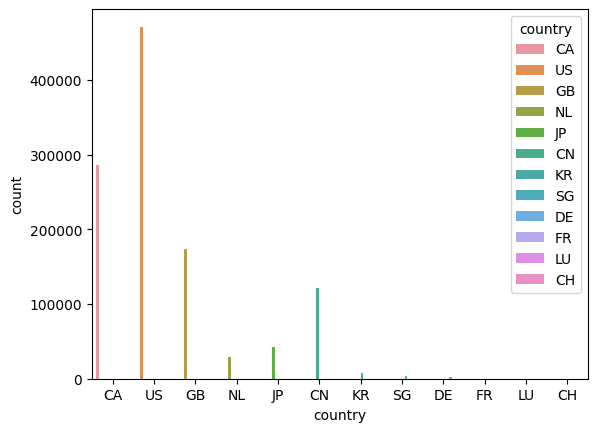

In [105]:
sns.countplot(koch, x="country", hue="country")

<AxesSubplot: xlabel='region', ylabel='count'>

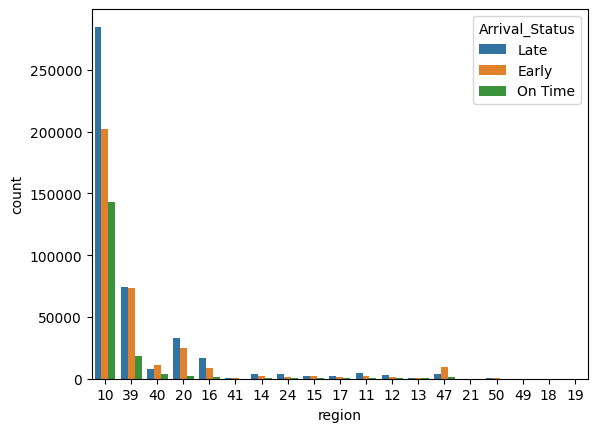

In [73]:
import seaborn as sns
import matplotlib.pyplot as plt
koch = koch.dropna(subset=['Time_Difference'])

sns.countplot(koch, x="region", hue="Arrival_Status")


In [51]:
koch.shape

(959086, 25)

C:\Users\Dann_\AppData\Local\Temp\ipykernel_31276\911448519.py:15: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  g.fig.show()


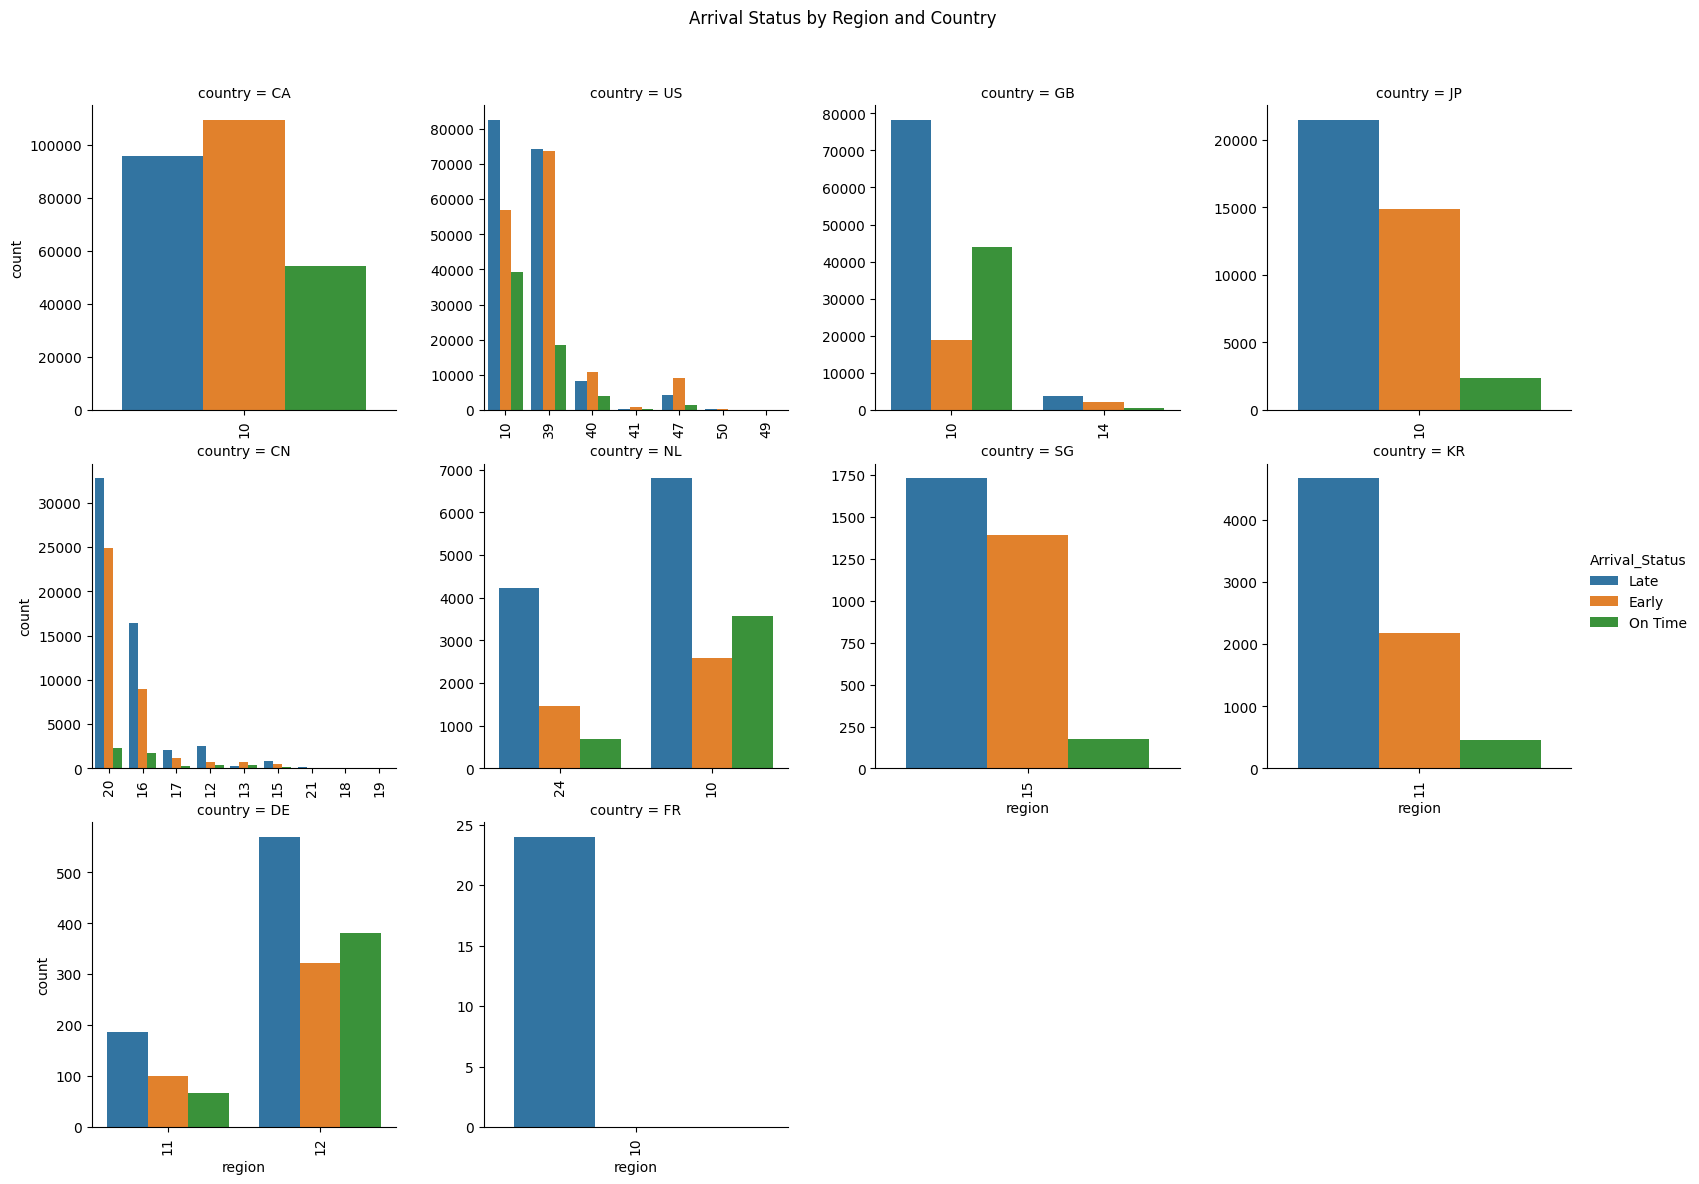

In [74]:
# Load your dataset
data = koch[['country', 'region', 'Arrival_Status']]

# Use catplot to create a count plot on 'region' with hue 'Arrival_Status', facetted by 'country'
g = sns.catplot(data=data, kind='count', x='region', hue='Arrival_Status', col='country', col_wrap=4, height=4, aspect=1, sharex=False, sharey=False)

# Rotate x-axis labels for readability if needed
g.set_xticklabels(rotation=90)

# Adjust spacing and layout
g.fig.subplots_adjust(top=0.9)  # adjust the Figure in g
g.fig.suptitle('Arrival Status by Region and Country')

# Show plot
g.fig.show()

In [77]:
koch.shape

(959086, 25)

In [75]:
koch.isna().sum()

PURCHASE_DOCUMENT_ID                           0
CREATE_DATE                                    0
COMPANY_CODE_ID                                0
VENDOR_ID                                 182957
POSTAL_CD                                 183927
RELEASE_DATE                              945562
PURCHASE_DOCUMENT_ITEM_ID                      0
MATERIAL_ID                               437382
SUB_COMMODITY_DESC                           190
MRP_TYPE_ID                               437382
MRP_TYPE_DESC_E                           437382
SHORT_TEXT                                     2
PLANT_ID                                       4
POR_DELIVERY_DATE                         636604
FIRST_GR_POSTING_DATE                          0
DELIVERY_DATE                                  0
REQUESTED_DELIVERY_DATE                       31
INBOUND_DELIVERY_ID                       501397
INBOUND_DELIVERY_ITEM_ID                       0
PLANNED_DELIVERY_DAYS                          0
BI_LAST_UPDATED_PURC

<AxesSubplot: xlabel='country', ylabel='count'>

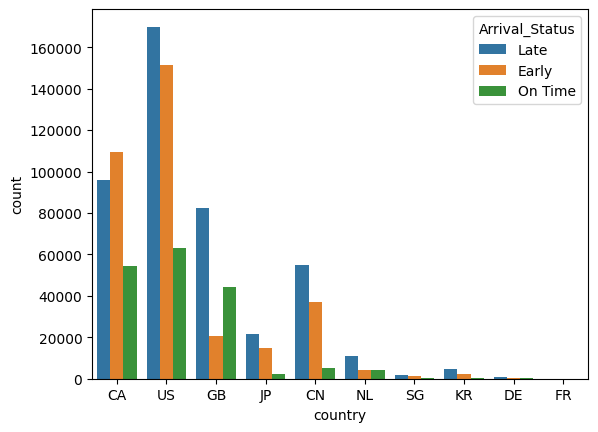

In [40]:
import seaborn as sns
sns.countplot(koch, x='country', hue="Arrival_Status")

In [42]:
koch.corr()

C:\Users\Dann_\AppData\Local\Temp\ipykernel_31276\3775191888.py:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  koch.corr()


,PURCHASE_DOCUMENT_ID,CREATE_DATE,RELEASE_DATE,PURCHASE_DOCUMENT_ITEM_ID,MATERIAL_ID,MRP_TYPE_ID,MRP_TYPE_DESC_E,PLANT_ID,INBOUND_DELIVERY_ID,INBOUND_DELIVERY_ITEM_ID,Time_Difference
PURCHASE_DOCUMENT_ID,1.000000,-0.447598,0.973145,-0.067820,-0.026805,-0.089837,-0.089837,-0.116759,0.067220,0.137625,0.013045
CREATE_DATE,-0.447598,1.000000,0.978268,0.019132,-0.151960,0.057505,0.057505,0.126165,0.862824,-0.037265,-0.003790
RELEASE_DATE,0.973145,0.978268,1.000000,0.058318,-0.428607,0.129329,0.129329,0.390877,0.978144,0.015586,-0.039788
PURCHASE_DOCUMENT_ITEM_ID,-0.067820,0.019132,0.058318,1.000000,-0.047315,-0.025699,-0.025699,0.065652,0.039911,-0.079710,0.007318
MATERIAL_ID,-0.026805,-0.151960,-0.428607,-0.047315,1.000000,0.053123,0.053123,-0.099694,-0.108986,0.072350,0.031020
MRP_TYPE_ID,-0.089837,0.057505,0.129329,-0.025699,0.053123,1.000000,1.000000,-0.089920,0.074652,0.015430,0.003995
MRP_TYPE_DESC_E,-0.089837,0.057505,0.129329,-0.025699,0.053123,1.000000,1.000000,-0.089920,0.074652,0.015430,0.003995
PLANT_ID,-0.116759,0.126165,0.390877,0.065652,-0.099694,-0.089920,-0.089920,1.000000,-0.017856,-0.125070,-0.054153
INBOUND_DELIVERY_ID,0.067220,0.862824,0.978144,0.039911,-0.108986,0.074652,0.074652,-0.017856,1.000000,0.030787,0.035110
INBOUND_DELIVERY_ITEM_ID,0.137625,-0.037265,0.015586,-0.079710,0.072350,0.015430,0.015430,-0.125070,0.030787,1.000000,0.030571


In [30]:
koch['Time_Difference'].isnull().sum()

180321

In [17]:
ed = 1139407/(i*100)
ed

0.06318770414982171

In [10]:
=koch.shape

(1139407, 22)

In [24]:
koch.shape

(1139407, 23)

,PURCHASE_DOCUMENT_ID,CREATE_DATE,COMPANY_CODE_ID,VENDOR_ID,POSTAL_CD,RELEASE_DATE,PURCHASE_DOCUMENT_ITEM_ID,MATERIAL_ID,SUB_COMMODITY_DESC,MRP_TYPE_ID,...,SHORT_TEXT,PLANT_ID,POR_DELIVERY_DATE,FIRST_GR_POSTING_DATE,DELIVERY_DATE,REQUESTED_DELIVERY_DATE,INBOUND_DELIVERY_ID,INBOUND_DELIVERY_ITEM_ID,PLANNED_DELIVERY_DAYS,BI_LAST_UPDATED_PURCHASE_DOCUMENT_ITEM
0,2000008134,20210726,CA10,8010005836,N2C 0B7,NaN,30.0,NaN,Machinery & Equipment,NaN,...,"1/2"" OD x 0.063"" Wall 20' Long ASTM A51",4036.0,NaN,20210812.0,20210806.0,20210806.0,NaN,0.0,0.0,2023-05-30 23:07:43.640
1,5100146560,20210726,US10,None,None,NaN,130.0,2.100008e+09,Custom Manufacturing,1.0,...,994 45 9951A TU E 4.99-8.62 3X0X 4014,4016.0,20210914.0,20210914.0,20210910.0,20210910.0,185979544.0,10.0,3.0,2021-11-08 03:52:05.270
2,5501410919,20210726,CA10,8010003139,L6H 5T5,NaN,10.0,NaN,Infrastructure Services,NaN,...,B66 RECHARGE PORTABLE SAFETY SHOWER 2021,4036.0,NaN,0.0,20210802.0,20210802.0,NaN,0.0,0.0,2023-09-07 10:07:29.323
3,2000008138,20210726,CA10,8010005836,N2C 0B7,NaN,20.0,NaN,Piping & Tubing,NaN,...,"5/8"" x 50 ft Black Rubber ProFitter[REG]",4036.0,NaN,20210803.0,20210827.0,20210827.0,NaN,0.0,0.0,2023-05-30 23:07:43.640
4,2000008136,20210726,CA10,8010005836,N2C 0B7,NaN,40.0,NaN,Material Handling,NaN,...,4XL - HI-VIZ SAFETY LONG-SLEEVED SHIRT -,4036.0,NaN,20210730.0,20210805.0,20210805.0,NaN,0.0,0.0,2023-05-30 23:07:43.640


### Data cleaning

First, let's force headers to uppercase using Snowpark DataFrame operations for standardization when columns are later written to a Snowflake table.

In [5]:
# Force headers to uppercase
for colname in diamonds_df.columns:
    if colname == '"table"':
       new_colname = "TABLE_PCT"
    else:
        new_colname = str.upper(colname)
    diamonds_df = diamonds_df.with_column_renamed(colname, new_colname)

diamonds_df.show()

----------------------------------------------------------------------------------------------------
|"CARAT"  |"CUT"      |"COLOR"  |"CLARITY"  |"DEPTH"  |"TABLE_PCT"  |"PRICE"  |"X"   |"Y"   |"Z"   |
----------------------------------------------------------------------------------------------------
|0.23     |Ideal      |E        |SI2        |61.5     |55.0         |326      |3.95  |3.98  |2.43  |
|0.21     |Premium    |E        |SI1        |59.8     |61.0         |326      |3.89  |3.84  |2.31  |
|0.23     |Good       |E        |VS1        |56.9     |65.0         |327      |4.05  |4.07  |2.31  |
|0.29     |Premium    |I        |VS2        |62.4     |58.0         |334      |4.20  |4.23  |2.63  |
|0.31     |Good       |J        |SI2        |63.3     |58.0         |335      |4.34  |4.35  |2.75  |
|0.24     |Very Good  |J        |VVS2       |62.8     |57.0         |336      |3.94  |3.96  |2.48  |
|0.24     |Very Good  |I        |VVS1       |62.3     |57.0         |336      |3.95  |3.98 

Next, we standardize the category formatting for `CUT` using Snowpark DataFrame operations.

This way, when we write to a Snowflake table, there will be no inconsistencies in how the Snowpark DataFrame will read in the category names. Secondly, the feature transformations on categoricals will be easier to encode.

In [6]:
def fix_values(columnn):
    return F.upper(F.regexp_replace(F.col(columnn), '[^a-zA-Z0-9]+', '_'))

for col in ["CUT"]:
    diamonds_df = diamonds_df.with_column(col, fix_values(col))

diamonds_df.show()

----------------------------------------------------------------------------------------------------
|"CARAT"  |"COLOR"  |"CLARITY"  |"DEPTH"  |"TABLE_PCT"  |"PRICE"  |"X"   |"Y"   |"Z"   |"CUT"      |
----------------------------------------------------------------------------------------------------
|0.23     |E        |SI2        |61.5     |55.0         |326      |3.95  |3.98  |2.43  |IDEAL      |
|0.21     |E        |SI1        |59.8     |61.0         |326      |3.89  |3.84  |2.31  |PREMIUM    |
|0.23     |E        |VS1        |56.9     |65.0         |327      |4.05  |4.07  |2.31  |GOOD       |
|0.29     |I        |VS2        |62.4     |58.0         |334      |4.20  |4.23  |2.63  |PREMIUM    |
|0.31     |J        |SI2        |63.3     |58.0         |335      |4.34  |4.35  |2.75  |GOOD       |
|0.24     |J        |VVS2       |62.8     |57.0         |336      |3.94  |3.96  |2.48  |VERY_GOOD  |
|0.24     |I        |VVS1       |62.3     |57.0         |336      |3.95  |3.98  |2.47  |VER

Check the schema.

In [7]:
list(diamonds_df.schema)

[StructField('CARAT', DecimalType(3, 2), nullable=True),
 StructField('COLOR', StringType(16777216), nullable=True),
 StructField('CLARITY', StringType(16777216), nullable=True),
 StructField('DEPTH', DecimalType(3, 1), nullable=True),
 StructField('TABLE_PCT', DecimalType(3, 1), nullable=True),
 StructField('PRICE', LongType(), nullable=True),
 StructField('X', DecimalType(4, 2), nullable=True),
 StructField('Y', DecimalType(4, 2), nullable=True),
 StructField('Z', DecimalType(4, 2), nullable=True),
 StructField('CUT', StringType(16777216), nullable=True)]

Finally, let's cast the decimal types to DoubleType() since DecimalType() isn't support by Snowpark ML at the moment.

In [8]:
for colname in ["CARAT", "X", "Y", "Z", "DEPTH", "TABLE_PCT"]:
    diamonds_df = diamonds_df.with_column(colname, diamonds_df[colname].cast(DoubleType()))

diamonds_df.show()

----------------------------------------------------------------------------------------------------
|"COLOR"  |"CLARITY"  |"PRICE"  |"CUT"      |"CARAT"  |"X"   |"Y"   |"Z"   |"DEPTH"  |"TABLE_PCT"  |
----------------------------------------------------------------------------------------------------
|E        |SI2        |326      |IDEAL      |0.23     |3.95  |3.98  |2.43  |61.5     |55.0         |
|E        |SI1        |326      |PREMIUM    |0.21     |3.89  |3.84  |2.31  |59.8     |61.0         |
|E        |VS1        |327      |GOOD       |0.23     |4.05  |4.07  |2.31  |56.9     |65.0         |
|I        |VS2        |334      |PREMIUM    |0.29     |4.2   |4.23  |2.63  |62.4     |58.0         |
|J        |SI2        |335      |GOOD       |0.31     |4.34  |4.35  |2.75  |63.3     |58.0         |
|J        |VVS2       |336      |VERY_GOOD  |0.24     |3.94  |3.96  |2.48  |62.8     |57.0         |
|I        |VVS1       |336      |VERY_GOOD  |0.24     |3.95  |3.98  |2.47  |62.3     |57.0 

### Write cleaned data to a Snowflake table

In [9]:
diamonds_df.write.mode('overwrite').save_as_table('diamonds')

In [10]:
session.close()